In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import os
import torch
import torch.nn.functional as F
from rdkit import Chem
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import global_mean_pool, global_max_pool
%matplotlib inline

In [2]:
gpuid = 0
torch.cuda.set_device(gpuid)
print(torch.cuda.current_device())

0


In [3]:
from clsar.dataset import LSSNS, HSSMS
from clsar.feature import Gen39AtomFeatures
from clsar.model.model import ACANet_PNA, get_deg, _fix_reproducibility # model
from clsar.model.loss import ACALoss, get_best_cliff
_fix_reproducibility(42)

In [4]:
def train(train_loader, model, optimizer, aca_loss):

    total_examples = 0
    total_loss =  0    
    total_tsm_loss = 0
    total_reg_loss = 0   
    n_triplets = []
    n_pos_triplets = []
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index, 
                                        data.edge_attr, data.batch)
        
        loss_out = aca_loss(labels = data.y, 
                            predictions = predictions,
                            embeddings = embeddings)
        
        loss, reg_loss, tsm_loss, n, n_pos = loss_out
        
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs        
        total_reg_loss += float(reg_loss) * data.num_graphs        
        total_examples += data.num_graphs
        
        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))
        
        
    train_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    return train_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets


@torch.no_grad()
def test(test_loader, model):
    model.eval()
    mse = []
    for data in test_loader:
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())
    return float(torch.cat(mse, dim=0).mean().sqrt())

In [5]:
dataset_name = 'CHEMBL3979_EC50'
Dataset =  HSSMS #LSSNS 
epochs = 800
batch_size = 128
lr = 1e-4

pre_transform = Gen39AtomFeatures()
in_channels = pre_transform.in_channels
path = '../data/'


## model HPs
pub_args = {'in_channels':pre_transform.in_channels, 
            'edge_dim':pre_transform.edge_dim,
            'convs_layers': [64, 128, 256, 512],   
            'dense_layers': [256, 128, 32], 
            'out_channels':1, 
            'aggregators': ['mean', 'min', 'max', 'sum','std'],
            'scalers':['identity', 'amplification', 'attenuation'] ,
            'dropout_p': 0}

dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(123)
len(dataset)

1125

In [6]:
# train, valid, test splitting
N = len(dataset) // 5
val_dataset = dataset[:N]
test_dataset = dataset[N:2 * N]
train_dataset = dataset[2 * N:]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
deg = get_deg(train_dataset)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
def Test_performance(alpha=1.0):
    
    model = ACANet_PNA(**pub_args, deg=deg).to(device)  
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10**-5)
    aca_loss = ACALoss(alpha=alpha, cliff_lower = 1., cliff_upper = 1.)
    
    history = []
    #ls_his = []
    for epoch in range(1, epochs):
        train_loss, tsm_loss, reg_loss, n_triplets, n_pos_triplets = train(train_loader, model, optimizer, aca_loss)
        val_rmse = test(val_loader, model)
        test_rmse = test(test_loader, model)
        
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} tsm_loss: {tsm_loss:.4f} reg_loss: {reg_loss:.4f} '
              f'n_pos_triplets: {n_pos_triplets:03d};  Val: {val_rmse:.4f} Test: {test_rmse:.4f}')
    
        history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':tsm_loss,'train_mae_loss':reg_loss,
                        'val_rmse':val_rmse, 'test_rmse':test_rmse, 'n_triplets': n_triplets, 'n_pos_triplets':n_pos_triplets})
        #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
    dfh = pd.DataFrame(history)
    return dfh

# With AC-Awareness ($\alpha = 1$)

In [8]:
df1 = Test_performance(alpha=1.0)

/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/opt/conda/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
/opt/conda/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch: 001, Loss: 11.1902 tsm_loss: 4.5752 reg_loss: 6.6150 n_pos_triplets: 220822;  Val: 6.6740 Test: 6.8938
Epoch: 002, Loss: 8.3593 tsm_loss: 2.1439 reg_loss: 6.2155 n_pos_triplets: 232690;  Val: 6.6723 Test: 6.8920
Epoch: 003, Loss: 7.3918 tsm_loss: 1.7019 reg_loss: 5.6900 n_pos_triplets: 232549;  Val: 6.6676 Test: 6.8873
Epoch: 004, Loss: 6.5077 tsm_loss: 1.5308 reg_loss: 4.9769 n_pos_triplets: 234271;  Val: 6.6377 Test: 6.8571
Epoch: 005, Loss: 5.4475 tsm_loss: 1.3878 reg_loss: 4.0597 n_pos_triplets: 224565;  Val: 6.4757 Test: 6.6931
Epoch: 006, Loss: 4.0946 tsm_loss: 1.3788 reg_loss: 2.7158 n_pos_triplets: 218453;  Val: 6.0398 Test: 6.2518
Epoch: 007, Loss: 2.5636 tsm_loss: 1.4171 reg_loss: 1.1465 n_pos_triplets: 198053;  Val: 5.1253 Test: 5.3275
Epoch: 008, Loss: 2.2257 tsm_loss: 1.3488 reg_loss: 0.8769 n_pos_triplets: 190208;  Val: 3.6528 Test: 3.8320
Epoch: 009, Loss: 2.0368 tsm_loss: 1.2575 reg_loss: 0.7793 n_pos_triplets: 208253;  Val: 2.2861 Test: 2.4332
Epoch: 010, Loss: 

# Without AC-Awareness ($\alpha = 0$)

In [9]:
df2 = Test_performance(alpha=0.0)

/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 6.3320 tsm_loss: 11.7503 reg_loss: 6.3320 n_pos_triplets: 223866;  Val: 6.6718 Test: 6.8916
Epoch: 002, Loss: 5.5642 tsm_loss: 14.0594 reg_loss: 5.5642 n_pos_triplets: 211919;  Val: 6.6720 Test: 6.8918
Epoch: 003, Loss: 4.6279 tsm_loss: 15.8116 reg_loss: 4.6279 n_pos_triplets: 209724;  Val: 6.6729 Test: 6.8927
Epoch: 004, Loss: 3.3679 tsm_loss: 16.0055 reg_loss: 3.3679 n_pos_triplets: 207295;  Val: 6.6716 Test: 6.8915
Epoch: 005, Loss: 1.7573 tsm_loss: 15.9193 reg_loss: 1.7573 n_pos_triplets: 212261;  Val: 6.6606 Test: 6.8800
Epoch: 006, Loss: 0.9380 tsm_loss: 14.2271 reg_loss: 0.9380 n_pos_triplets: 206268;  Val: 6.2228 Test: 6.4364
Epoch: 007, Loss: 0.8213 tsm_loss: 12.3759 reg_loss: 0.8213 n_pos_triplets: 196793;  Val: 5.0339 Test: 5.2251
Epoch: 008, Loss: 0.8086 tsm_loss: 11.3815 reg_loss: 0.8086 n_pos_triplets: 197648;  Val: 3.8438 Test: 4.0098
Epoch: 009, Loss: 0.7156 tsm_loss: 10.0017 reg_loss: 0.7156 n_pos_triplets: 198422;  Val: 3.0546 Test: 3.1860
Epoch: 010

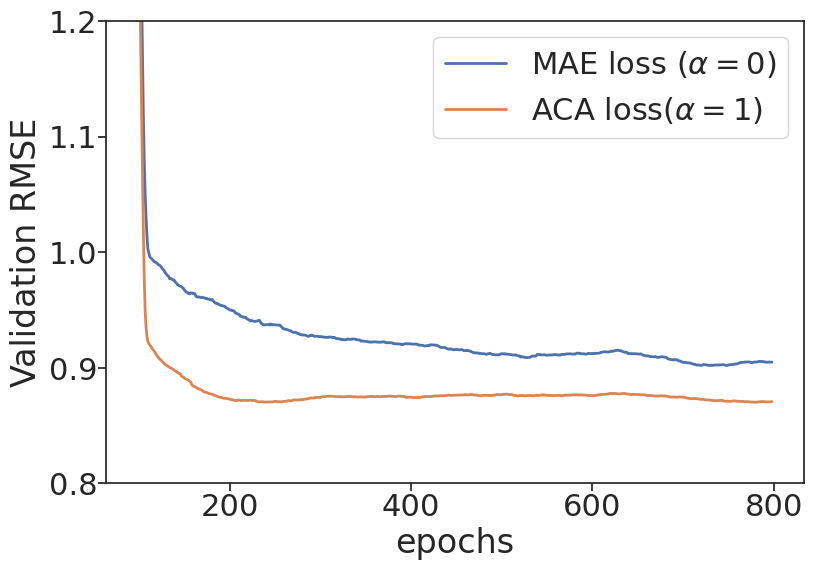

In [10]:
save_dir = '../results/%s/' % dataset_name
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig, ax = plt.subplots(figsize=(9, 6))
df2.val_rmse.to_frame(name = r'MAE loss ($\alpha = 0 $)').join(df1.val_rmse.to_frame(name = r'ACA loss($\alpha=1$)')).rolling(100).mean().plot(lw = 2, ax=ax)
ax.set_ylim(0.8, 1.2)
ax.set_ylabel('Validation RMSE')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('../results/%s/Validation_RMSE.png' % dataset_name, bbox_inches='tight', dpi=400) 

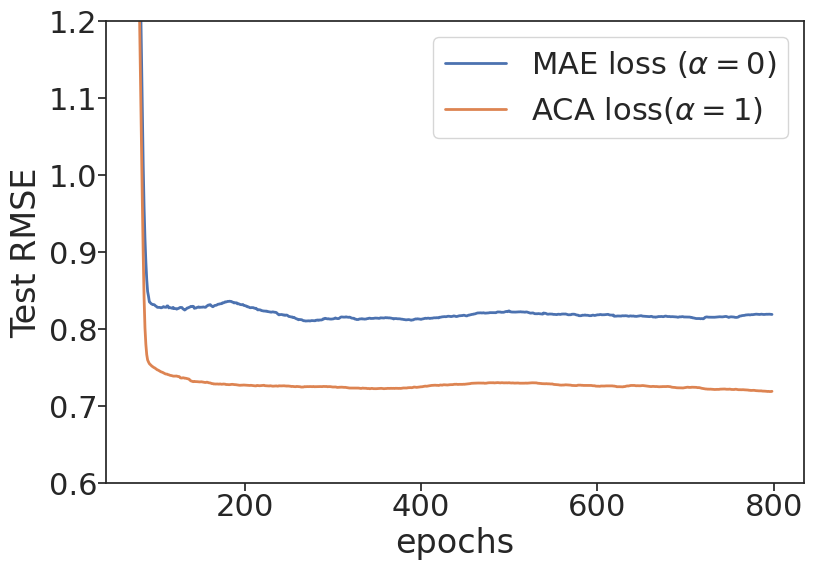

In [11]:
fig, ax = plt.subplots(figsize=(9, 6))

df2.test_rmse.to_frame(name = r'MAE loss ($\alpha = 0 $)').join(df1.test_rmse.to_frame(name = r'ACA loss($\alpha=1$)')).rolling(80).mean().plot(lw = 2, ax=ax)
ax.set_ylim(0.6, 1.2)

ax.set_ylabel('Test RMSE')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('../results/%s/Test_RMSE.png' % dataset_name, bbox_inches='tight', dpi=400) 

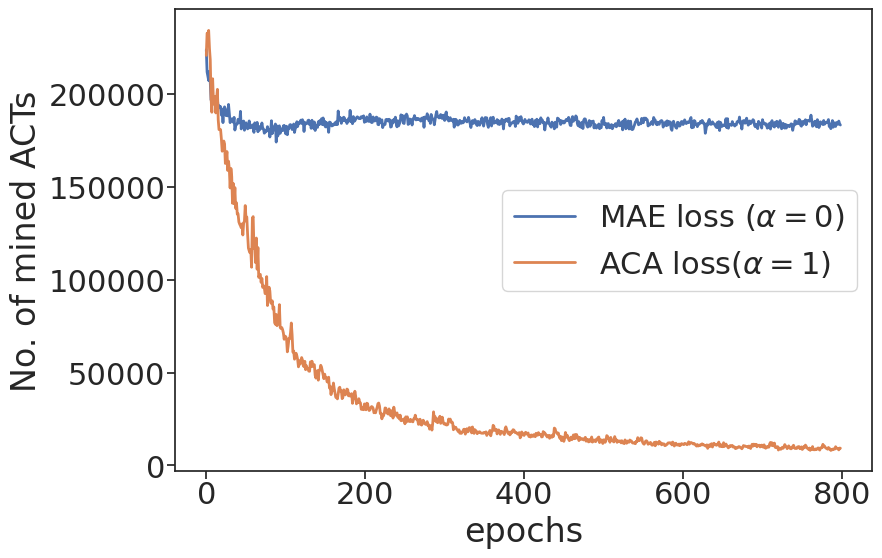

In [12]:
fig, ax = plt.subplots(figsize=(9, 6))
df2.n_pos_triplets.to_frame(name = r'MAE loss ($\alpha = 0 $)').join(df1.n_pos_triplets.to_frame(name =  r'ACA loss($\alpha=1$)')).rolling(1).mean().plot(lw=2, ax=ax)
ax.set_ylabel('No. of mined ACTs')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('../results/%s/Number_of_mined_ACTs_during_training.png' % dataset_name, bbox_inches='tight', dpi=400) 

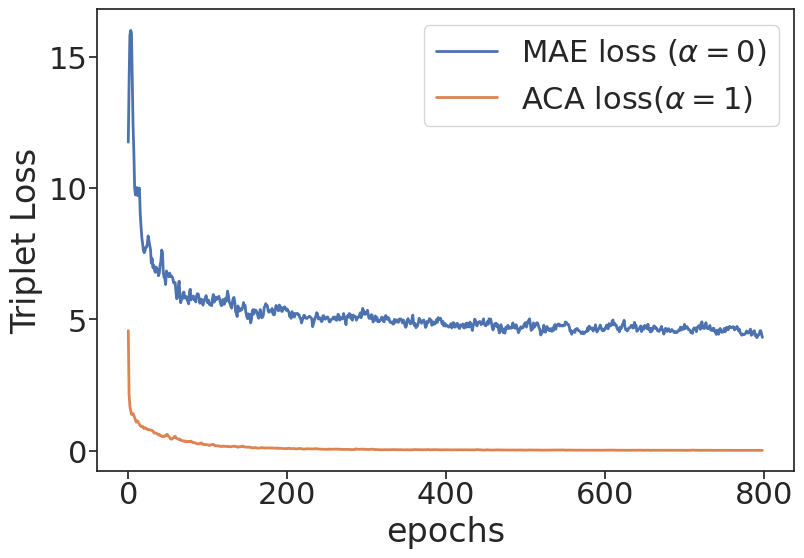

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))
df2.train_triplet_loss.to_frame(name = r'MAE loss ($\alpha = 0 $)').join(df1.train_triplet_loss.to_frame(name = r'ACA loss($\alpha=1$)')).plot(lw=2, ax=ax)
ax.set_ylabel('Triplet Loss')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('../results/%s/Triplet_loss_during_training.png' % dataset_name, bbox_inches='tight', dpi=400) 